# Recommender Systems Assignment

# Instructions 
This is a tutorial cum assignment on recommender systems. 
There are three modules in the assignment:
1. Content Based Recommender Systems
2. Collaborative Filtering Based Recommender Systems
3. Evaluation Metrics for Recommender Systems

There are example code snippets in each of the module followed by some practise questions. The sample code snippets will help you in answering the practise questions.

# Know Your Data

We will first try to understand our data. There are two datasets used in the entire assignment. The data files are provided in the assignment folder itself. 
1. Module 1 on content based recommendations uses IMDB movie dataset "Content_file_IMDB.csv" consisting of movie information on 250 popular movies.  

2. Module 2 on collaborative filtering uses movie lens data. There are two data files for module 2.

    a. File "u.data". Will be used for Collaborative filtering.
 
    b. A sparse version of the same data "u_sparse.data". Will be used for cold start recommendations.
    The files are tab seperated and contain the entities in following order: UserId, MovieID, rating given by user UserId to MovieID and the timestamp.
    
    
Below are some visualizations of these datasets.    

In [1]:
# Data for content based recommendations
import pandas as pd


pd.set_option('display.max_columns', 100)
df = pd.read_csv('Content_file_IMDB.csv')

print("The dimensions of data ")
print(df.shape)
print("Sample data")
df.head(2) # display top two rows of the data

The dimensions of data 
(250, 38)
Sample data


,Unnamed: 0,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings.Source,Ratings.Value,Metascore,imdbRating,imdbVotes,imdbID,Type,tomatoMeter,tomatoImage,tomatoRating,tomatoReviews,tomatoFresh,tomatoRotten,tomatoConsensus,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,tomatoURL,DVD,BoxOffice,Production,Website,Response
0,1,The Shawshank Redemption,1994,R,14 Oct 1994,142 min,"Crime, Drama",Frank Darabont,"Stephen King (short story ""Rita Hayworth and S...","Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Two imprisoned men bond over a number of years...,English,USA,Nominated for 7 Oscars. Another 19 wins & 30 n...,https://images-na.ssl-images-amazon.com/images...,Internet Movie Database,9.3/10,80.0,9.3,"1,825,626",tt0111161,movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/shawshank_rede...,27 Jan 1998,NaN,Columbia Pictures,NaN,True
1,2,The Godfather,1972,R,24 Mar 1972,175 min,"Crime, Drama",Francis Ford Coppola,"Mario Puzo (screenplay), Francis Ford Coppola ...","Marlon Brando, Al Pacino, James Caan, Richard ...",The aging patriarch of an organized crime dyna...,"English, Italian, Latin",USA,Won 3 Oscars. Another 23 wins & 27 nominations.,https://images-na.ssl-images-amazon.com/images...,Internet Movie Database,9.2/10,100.0,9.2,"1,243,444",tt0068646,movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/godfather/,09 Oct 2001,NaN,Paramount Pictures,http://www.thegodfather.com,True


In [2]:
# Data for collaborative filtering

import pandas as pd

collaborative_data = pd.read_csv('ml-100k/u.data', sep=" ", header=None) # load the data

print("[UserId, MoviedId ,Rating ,Timestamp]")
print("The dimensions of data ")
print(collaborative_data.shape)
print("Sample data")
print(collaborative_data.iloc[0].str.split('\t'))# first row of the file iloc[index]
print(collaborative_data.iloc[1].str.split('\t')) # since it is tab seperated split the line using tab '\t'


[UserId, MoviedId ,Rating ,Timestamp]
The dimensions of data 
(100000, 1)
Sample data
0    [196, 242, 3, 881250949]
Name: 0, dtype: object
0    [186, 302, 3, 891717742]
Name: 1, dtype: object


# Module 1: Content Based Recommendations
In this module we will learn to:
1. Construct content based feature vectors for items(movies).
2. Compute similarity between the items to recommend similar items.

Pre-processing data. Choosing the required features(columns).

In [3]:
import pandas as pd


pd.set_option('display.max_columns', 100)
df = pd.read_csv('Content_file_IMDB.csv')
df = df[['Title','Genre','Director','Actors','Plot']]
# df.head()

Transforming the full names of actors and directors in single words so they are considered as unique values.

In [4]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from rake_nltk import Rake

# discarding the commas between the actors' full names and getting only the first three names

df['Actors'] = df['Actors'].map(lambda x: x.split(',')[:3])

# putting the genres in a list of words
df['Genre'] = df['Genre'].map(lambda x: x.lower().split(','))

df['Director'] = df['Director'].map(lambda x: x.split(' '))

# merging together first and last name for each actor and director, so it's considered as one word 
# and there is no mix up between people sharing a first name
for index, row in df.iterrows():
    row['Actors'] = [x.lower().replace(' ','') for x in row['Actors']]
    row['Director'] = ''.join(row['Director']).lower()

Extracting the key words from the plot description to make movie profiles. Text preprocessing.

In [5]:
# New column to store the keywords of the plot
df['Key_words'] = ""

for index, row in df.iterrows():
    plot = row['Plot']
    
    # instantiating Rake, by default is uses english stopwords from NLTK
    # and discard all puntuation characters
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(plot)

    # getting the dictionary whith key words and their scores
    key_words_dict_scores = r.get_word_degrees()
    
    # assigning the key words to the new column
    row['Key_words'] = list(key_words_dict_scores.keys())

# dropping the Plot column
# df.drop(columns = ['Plot'], inplace = True)
df.drop('Plot',axis = 1, inplace = True)
df.set_index('Title', inplace = True)

In [6]:
# constructing bag of words vectors for movies
df['bag_of_words'] = ''
columns = df.columns
for index, row in df.iterrows():
#     print("index %s and row %s"%(index,row))
    words = ''
    for col in columns:
        if col != 'Director': # only one word in the column
            words = words + ' '.join(row[col])+ ' '
        else:
            words = words + row[col]+ ' '
    row['bag_of_words'] = words
    
# df.drop(columns = [col for col in df.columns if col!= 'bag_of_words'], inplace = True)
df.drop([col for col in df.columns if col!= 'bag_of_words'], axis = 1, inplace = True)

Obtaining the representations for movies

In [13]:
#Construct content based feature vectors for items(movies)
# Solution


from sklearn.feature_extraction.text import TfidfVectorizer
# instantiating and generating the count matrix
count = TfidfVectorizer()

count_matrix = count.fit_transform(df['bag_of_words'])

# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use later to match the indexes

indices = pd.Series(df.index)
indices[:5]

0    The Shawshank Redemption
1               The Godfather
2      The Godfather: Part II
3             The Dark Knight
4                12 Angry Men
Name: Title, dtype: object

# EXERCISE
1. In the above snippet use TfidfVectorizer instead of CountVectorizer and report the change in predictions.
2. What is the aim of TFIDF?

# SOLUTION

In [14]:
# generating the cosine similarity matrix
# Solution  X = count_matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim

array([[ 1.        ,  0.02996184,  0.02611648, ...,  0.00386164,
         0.00383188,  0.00372325],
       [ 0.02996184,  1.        ,  0.1914016 , ...,  0.00420721,
         0.00417478,  0.00405643],
       [ 0.02611648,  0.1914016 ,  1.        , ...,  0.00366725,
         0.00363898,  0.00353582],
       ..., 
       [ 0.00386164,  0.00420721,  0.00366725, ...,  1.        ,
         0.00390566,  0.00379494],
       [ 0.00383188,  0.00417478,  0.00363898, ...,  0.00390566,
         1.        ,  0.00376569],
       [ 0.00372325,  0.00405643,  0.00353582, ...,  0.00379494,
         0.00376569,  1.        ]])

# EXERCISE
After getting the representations from CountVectorizer, we need to get  similarity between the movies.
Cosine similarity is one such similarity measure.
2. In the above code replace X with the relevant element to compute the cosine similarity matrix.
Hint: X has the representations of the documents
3. How is X interpreted? (Strucrure of X)


In [15]:
# Compute similarity between the items to recommend similar items.

# function that takes in movie title as input and returns the top 10 recommended movies
def recommendations(title, cosine_sim = cosine_sim):
    
    recommended_movies = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(df.index)[i])
        
    return recommended_movies

In [16]:
recommendations('Fargo') 

['No Country for Old Men',
 'The Big Lebowski',
 'Laura',
 'Harvey',
 'The Departed',
 'Reservoir Dogs',
 'Touch of Evil',
 'Prisoners',
 'Rope',
 'Heat']

# SOLUTION

In [18]:
# print(indices)
# movieid 16 is the movie The Matrix
recommendations('The Matrix') 

['2001: A Space Odyssey',
 'Memento',
 'Guardians of the Galaxy Vol. 2',
 'Mad Max: Fury Road',
 'The Terminator',
 'Alien',
 'Guardians of the Galaxy',
 'How to Train Your Dragon',
 'Aliens',
 'A Streetcar Named Desire']

# EXERCISE
4. A user likes the movie id 16 what will be the top 10 recommendations for the user?


# Module 2: Collaborative Filtering
In this module we will learn to build collaborative recommender systems using a python library for collborative filtering called "surprise". It implements collaborative filtering model based methods like NMF,PMF,SVD and memory based collaborative filtering techniques such as KNN.

Collaborative filtering methods work with utility matrices containg user x item ratings. Every cell in the utility matrix corresponds to the rating given by user "i" to item  to "j".

This module has two parts:


a. Building a collaborative system using SVD: Using the utility matrix the system predicts ratings for a new user-item pair and evaluate the performance using RMSE.


b. System Cold Start Problem: Predicting ratings when the utility is relatively sparse i.e. majority of the cells in the matrix are empty. The amount of empty cells is given by the sparsity of the matrix.
Sparsity is given by:
\begin{equation*}
1-\frac{|RATINGS|}{|USERS|*|ITEMS|}
\end{equation*}


In [19]:
# Solution changing the number of factors and epochs
#Building a collaborative system using SVD


from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from surprise import SVDpp
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

# Use movielens-100K
reader = Reader(line_format='user item rating timestamp', sep='\t')
data = Dataset.load_from_file('ml-100k/u.data',reader=reader)
# data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=.15)

# ----- SVD ----- # 

rmse_dict = {}
for i in range (0,200,5):
    algo = SVD(n_factors=200, n_epochs=int(i), lr_all=0.005, reg_all=0.1) # Setting up the SVD algorithm using hyperparameters.
    algo.fit(trainset)
    test_pred = algo.test(testset)
    rmse_dict[i] = accuracy.rmse(test_pred, verbose=True)
    
# print("SVD : Test Set")
# accuracy.rmse(test_pred, verbose=True)

RMSE: 1.1334
RMSE: 0.9603
RMSE: 0.9475
RMSE: 0.9418
RMSE: 0.9341
RMSE: 0.9287
RMSE: 0.9228
RMSE: 0.9197
RMSE: 0.9145
RMSE: 0.9134
RMSE: 0.9125
RMSE: 0.9124
RMSE: 0.9093
RMSE: 0.9092
RMSE: 0.9080
RMSE: 0.9085
RMSE: 0.9078
RMSE: 0.9068
RMSE: 0.9071
RMSE: 0.9078
RMSE: 0.9067
RMSE: 0.9066
RMSE: 0.9063
RMSE: 0.9063
RMSE: 0.9073
RMSE: 0.9074
RMSE: 0.9072
RMSE: 0.9075
RMSE: 0.9078
RMSE: 0.9083
RMSE: 0.9082
RMSE: 0.9076
RMSE: 0.9081
RMSE: 0.9082
RMSE: 0.9078
RMSE: 0.9082
RMSE: 0.9091
RMSE: 0.9079
RMSE: 0.9081
RMSE: 0.9083


In [73]:
# Sparsity of the dataset.

print("Number of items %s"%(data.build_full_trainset().n_items)) # number of rows
print("Number of users %s"%(data.build_full_trainset().n_users)) # number of columns
print("Number of ratings %s"%(data.build_full_trainset().n_ratings)) # non empty cells in the utility matrix
sparsity  = 1-((data.build_full_trainset().n_ratings)/(data.build_full_trainset().n_items*data.build_full_trainset().n_users))
print("sparsity of data is %s"%(sparsity))

Number of items 1682
Number of users 943
Number of ratings 100000
sparsity of data is 0.9369533063577546


In [9]:
# creating a sparse file, uncomment to create your own sparse file. Every line in the file corresponds to a rating by user to a movie
# import random
# f = open('sparse/ml-100k_sparse/u_spar_sor.data','r')
# lines = f.readlines()
# print(len(lines))
# deleted = []
# number  = int(int(len(lines))*0.40)
# indices_to_delete = random.sample(range(len(lines)),number )

# # sort to delete biggest index first 
# indices_to_delete.sort(reverse=True)

# for i in indices_to_delete:
#     # lines.pop(i) delete item at index i and return the item
#     # do you need it or its index in the original file than
#     deleted.append((i, lines.pop(i)))
# f.close()    
# print(len(deleted))   
# with open('/home/sailaja/research/jupyter_code/Recommender-System-Assignment/sparse/ml-100k_sparse/u_sparse.data','w') as g:
#     for line in lines:
#         if line not in deleted:
#             g.write(line)
# g.close()            
# # print(deleted)

100001
40000


In [21]:
#System Cold Start Problem
# Solution changing the number of factors and epochs


from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from surprise import SVDpp
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate




# Use movielens-100K
reader = Reader(line_format='user item rating timestamp', sep='\t')
data_sparse = Dataset.load_from_file('sparse/ml-100k_sparse/u_sparse.data',reader=reader)
# data = Dataset.load_builtin('ml-100k')
trainset_sparse, testset_sparse = train_test_split(data_sparse, test_size=.15)

# ----- SVD ----- #

# Use the new parameters with the train data
rmse_dict_sparse = {}
for i in range (0,200,5):
    algo = SVD(n_factors=200, n_epochs=int(i), lr_all=0.005, reg_all=0.1)
    algo.fit(trainset_sparse)
    test_pred = algo.test(testset_sparse)
    rmse_dict_sparse[i] = accuracy.rmse(test_pred, verbose=True)
    
# print("SVD : Test Set")
# accuracy.rmse(test_pred, verbose=True)

print(data_sparse.build_full_trainset().n_items)
print(data_sparse.build_full_trainset().n_users)
print(data_sparse.build_full_trainset().n_ratings)
sparsity  = 1-((data_sparse.build_full_trainset().n_ratings)/(data_sparse.build_full_trainset().n_items*data_sparse.build_full_trainset().n_users))
print("sparsity of data is %s"%(sparsity))







RMSE: 1.1312
RMSE: 0.9784
RMSE: 0.9645
RMSE: 0.9587
RMSE: 0.9546
RMSE: 0.9531
RMSE: 0.9482
RMSE: 0.9472
RMSE: 0.9431
RMSE: 0.9428
RMSE: 0.9416
RMSE: 0.9410
RMSE: 0.9383
RMSE: 0.9372
RMSE: 0.9382
RMSE: 0.9384
RMSE: 0.9369
RMSE: 0.9341
RMSE: 0.9364
RMSE: 0.9370
RMSE: 0.9362
RMSE: 0.9378
RMSE: 0.9363
RMSE: 0.9369
RMSE: 0.9377
RMSE: 0.9376
RMSE: 0.9380
RMSE: 0.9364
RMSE: 0.9366
RMSE: 0.9381
RMSE: 0.9373
RMSE: 0.9377
RMSE: 0.9369
RMSE: 0.9368
RMSE: 0.9358
RMSE: 0.9373
RMSE: 0.9375
RMSE: 0.9379
RMSE: 0.9352
RMSE: 0.9365
1607
943
60001
sparsity of data is 0.960405859571163


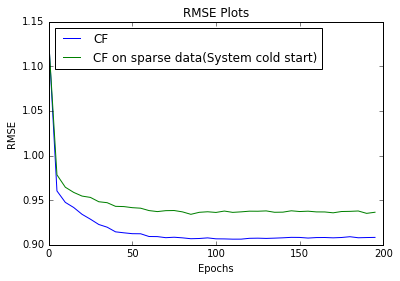

In [22]:
# Effects of sparsity on the data. 

import matplotlib.pylab as plt
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title("RMSE Plots")


lists = sorted(rmse_dict.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
lists = sorted(rmse_dict_sparse.items())
i,j = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.plot(i,j)
plt.legend(['CF', 'CF on sparse data(System cold start)'], loc='upper left')
plt.show()

## SOLUTION

2. Sparsity decreases the RMSE value since there is no enough train data. The system cannot make good predictions with less data.

# EXERCISE
1. In the above snippets, use tuning the hyperparameters like epochs and factors to witness change in the RMSE curve. 
2. Does sparsity effect RMSE? How?

In [ ]:
from surprise import KNNBasic
from surprise import Dataset
from surprise import Reader
import os
from surprise import NMF

#------------------------load data from a file
file_path = os.path.expanduser('ml-100k/u.data')
reader = Reader(line_format='user item rating timestamp', sep='\t')
data = Dataset.load_from_file(file_path, reader=reader)



from surprise import SVD
from surprise import evaluate, print_perf
import os


#########---------------SVD
print('')
print('---------------SVD result-------------')
data.split(n_folds=3)
algo = SVD()
perf = evaluate(algo, data, measures=['RMSE', 'MAE'])
print_perf(perf)


#########---------------PMF
print('')
print('---------------PMF result--------------')
data.split(n_folds=3)
algo = SVD(biased=False)
perf = evaluate(algo, data, measures=['RMSE', 'MAE'])
print_perf(perf)


##########--------MSD------User Based Collaborative Filtering algorithm
print('')
print('15--Neighboors--User Based Collaborative Filtering algorithm result')
data.split(n_folds=3)
algo = KNNBasic(k=10, sim_options = {'name':'MSD', 'user_based':True })
perf = evaluate(algo, data, measures=['RMSE'])
print_perf(perf)


## SOLUTION
1. Change 'user_based':True to 'user_based':False
2. MSD --> Compute the Mean Squared Difference similarity between all pairs of users (or items).
3. cosine in place of MSD
4. A table with different values for the hyperparameters.

Reference for error functions: https://surprise.readthedocs.io/en/stable/similarities.html

# EXERCISE
1. In the above code which part of the code to change to make it item-item collaborative filtering.
2. In the above snippet, what is the similarity measure used to compute similarity between two users in User Based Collaborative Filtering algorithm.
3. Use cosine similarity to compute the similarity in User Based Collaborative Filtering algorithm.
4. Compare the RMSE values of the above algorithms by playing around the hyperparameters such as the number of neighbours "k", number of cross validations folds "n_folds" the similarity measures "name" and record your observations.

# Module 3: Evaluation measures 
## EXERCISE
Evaluation measures depend on the nature of recommendations.
Such as RMSE is useful when predicting an exact value to a variable.
Given below are few evaluation measures map them to their corresponding descriptions. Use the indices to mark mappings 
such as 1-->a.

# Metric                   Description
1. F1$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; $a. The ratio of empty and total entries in the utility matrix. 
2. Precision$\;\;\;\;\;\;\;\;\;\;\;$b. Proportion of relevant results that are recommended.  
3. MAE$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$c. The proportion of results classified correctly(both positive and negative). 
4. Recall$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$d. Deviation between actual and predicted ratings. 
5. Accuracy$\;\;\;\;\;\;\;\;\;\;\;$e. Harmonic mean of precision and recall. 
6. Sparsity $\;\;\;\;\;\;\;\;\;\;\;\;$f. Proportion of recommended results that are relevant. 


# SOLUTION
1 --> e
2 --> f
3 --> d
4 --> b
5 --> c
6 --> a